In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings  # Hide unnecessary warnings in outputs
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

pd.set_option('display.max_columns', None)

bookings_df = pd.read_csv('Bookings_Data.csv')
bookings_df.head()

,ID,Sales Segment,Global Region,Industry,Booking Date Date,Lead Source,Type,Reporting Type Reason,Stage Name,Source,Number of Employees,Is Customer (Yes / No),Created Date,Tenure Months,Total ARR
0,1,Enterprise,NaN,Internet Software & Services,2024-06-27,Website,New Deal,New,Disqualified,Website,"10,001",Yes,2019-05-14,15 Months,$0.00
1,2,Enterprise,NaN,Internet Software & Services,2020-09-30,SalesLoft,New Deal,New,Closed Lost,SalesLoft,"3,100",No,2018-04-27,15 Months,$0.00
2,3,Emerging,NaN,NaN,2020-07-31,NaN,New Deal,New,Closed Lost,NaN,NaN,No,2019-03-22,47 Months,$102K
3,4,Emerging,NaN,NaN,2020-06-30,NaN,New Deal,New,Closed Lost,NaN,NaN,No,2019-11-27,47 Months,$11K
4,5,Emerging,NaN,Business Services,2020-06-30,NaN,New Deal,New,Closed Lost,NaN,NaN,No,2019-10-23,47 Months,$8K


In [13]:
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      3699 non-null   int64 
 1   Sales Segment           3699 non-null   object
 2   Global Region           524 non-null    object
 3   Industry                3331 non-null   object
 4   Booking Date Date       3699 non-null   object
 5   Lead Source             1170 non-null   object
 6   Type                    3699 non-null   object
 7   Reporting Type Reason   3676 non-null   object
 8   Stage Name              3699 non-null   object
 9   Source                  1170 non-null   object
 10  Number of Employees     3125 non-null   object
 11  Is Customer (Yes / No)  3699 non-null   object
 12  Created Date            3699 non-null   object
 13  Tenure Months           3693 non-null   object
 14  Total ARR               3699 non-null   object
dtypes: i

In [14]:
# Cleaning the Data
bookings_df = bookings_df.drop_duplicates()
bookings_df = bookings_df.dropna(subset=['Stage Name', 'ID']) # These two columns are essential for this analysis

# Converting the text column to date format
bookings_df['Booking Date Date'] = pd.to_datetime(bookings_df['Booking Date Date'])

# Adding a column for the opportunity status (Closed-Won)
bookings_df['opportunity_status'] = bookings_df['Stage Name'].apply(lambda x: 'Closed-Won' if x == 'Closed Won' else x)

# Confirm the column has been converted correctly
print(bookings_df['Booking Date Date'].head())
print(bookings_df.info())

0   2024-06-27
1   2020-09-30
2   2020-07-31
3   2020-06-30
4   2020-06-30
Name: Booking Date Date, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3699 entries, 0 to 3698
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      3699 non-null   int64         
 1   Sales Segment           3699 non-null   object        
 2   Global Region           524 non-null    object        
 3   Industry                3331 non-null   object        
 4   Booking Date Date       3699 non-null   datetime64[ns]
 5   Lead Source             1170 non-null   object        
 6   Type                    3699 non-null   object        
 7   Reporting Type Reason   3676 non-null   object        
 8   Stage Name              3699 non-null   object        
 9   Source                  1170 non-null   object        
 10  Number of Employees     3125 non-null   object

In [15]:
# Calculate the overall closing rate
closed_won = bookings_df[bookings_df['opportunity_status'] == 'Closed-Won'].shape[0]
total_opportunities = bookings_df['ID'].nunique()
close_rate = closed_won / total_opportunities * 100  # Convert to percentage

# Display the closing rate as a percentage
close_rate_percentage_formatted = f"Closing rate: {close_rate:.2f}%"
print(close_rate_percentage_formatted)

Closing rate: 79.59%


In [16]:
# Check the unique dates
unique_dates = bookings_df['Booking Date Date'].unique()
print(unique_dates)

<DatetimeArray>
['2024-06-27 00:00:00', '2020-09-30 00:00:00', '2020-07-31 00:00:00',
 '2020-06-30 00:00:00', '2020-05-31 00:00:00', '2020-05-29 00:00:00',
 '2020-05-27 00:00:00', '2020-05-01 00:00:00', '2020-04-30 00:00:00',
 '2020-04-21 00:00:00',
 ...
 '2019-03-12 00:00:00', '2019-03-11 00:00:00', '2019-03-10 00:00:00',
 '2019-03-09 00:00:00', '2019-03-08 00:00:00', '2019-03-07 00:00:00',
 '2019-03-06 00:00:00', '2019-03-05 00:00:00', '2019-03-04 00:00:00',
 '2019-03-01 00:00:00']
Length: 318, dtype: datetime64[ns]


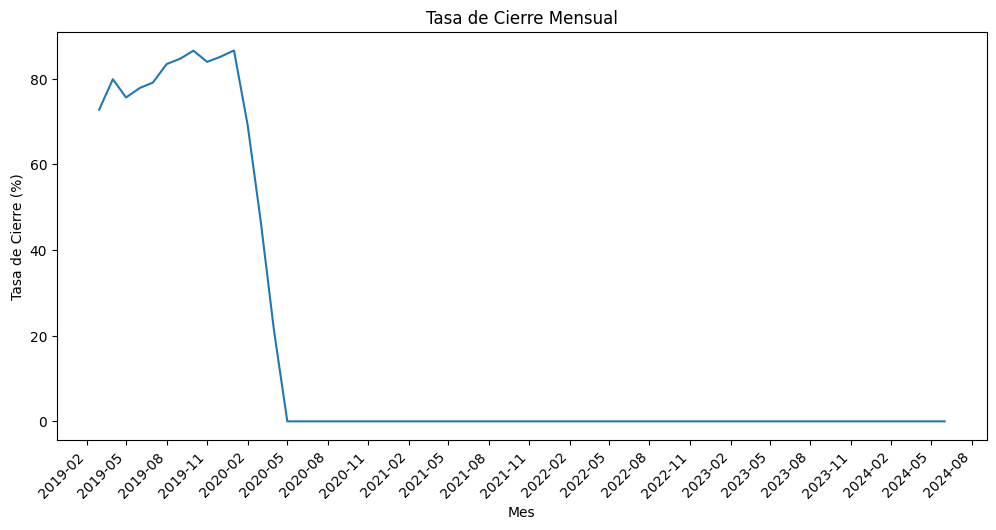

In [17]:
# Convert the date column to monthly periods for more detailed analysis
bookings_df['Booking Month'] = bookings_df['Booking Date Date'].dt.to_period('M')

# Monthly analysis of the closing rate
monthly_data = bookings_df.groupby('Booking Month').agg({
    'ID': 'nunique',
    'opportunity_status': lambda x: (x == 'Closed-Won').sum()
}).rename(columns={'ID': 'total_opportunities', 'opportunity_status': 'closed_won'})

monthly_data['close_rate'] = (monthly_data['closed_won'] / monthly_data['total_opportunities']) * 100

# Convert 'Booking Month' to datetime for accurate plotting
monthly_data.index = monthly_data.index.to_timestamp()

# Visualize the monthly closing rate
fig, ax = plt.subplots(figsize=(12, 6))
monthly_data['close_rate'].plot(kind='line', title='Tasa de Cierre Mensual', ax=ax)
ax.set_ylabel('Tasa de Cierre (%)')
ax.set_xlabel('Mes')

# Format x-axis labels to show month and year, reducing the number of labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Display a label every three months

plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.show()

There seem to be outliers. Let's dig deeper by counting the Opportunities by Year and Status:

In [18]:
# Extract the year from the date column
bookings_df['Year'] = bookings_df['Booking Date Date'].dt.year

# Count the number of opportunities per year
opportunities_per_year = bookings_df['Year'].value_counts().sort_index()
print(opportunities_per_year)


Year
2019    2892
2020     806
2024       1
Name: count, dtype: int64


There's a significant drop in the number of opportunities after 2019. This suggests that data post-2019 might be incomplete or not recorded correctly.

In [19]:
# Count the number of opportunities by year and status
opportunity_status_per_year = bookings_df.groupby(['Year', 'opportunity_status']).size().unstack(fill_value=0)
print(opportunity_status_per_year)


opportunity_status  Closed Lost  Closed-Won  Disqualified
Year                                                     
2019                        444        2344           104
2020                        164         600            42
2024                          0           0             1


* The number of recorded opportunities drops significantly after 2019. This might indicate an issue with data collection, especially since there's only one opportunity recorded for 2024.

* For 2024, there's only one opportunity recorded, and it's in Disqualified status. This suggests that the 2024 data may be incomplete or that the opportunity recording process has not been properly conducted.


_ _ _

## Recommendations Based on the Data

* Investigate the data collection and recording processes starting from 2020 to identify potential issues and ensure all opportunities are properly recorded.
  
#### Data Integrity Verification:

* Conduct a data audit to ensure integrity, particularly for the years after 2019.

* Train the staff responsible for data entry and enhance processes to prevent errors and ensure more robust data collection.

_ _ _

## Additional
To identify possible correlations that may have influenced the closing rate before the drastic drop, we will conduct exploratory data analysis and use some statistical techniques.

In [22]:
# Filter data before 2020
bookings_df_pre_2020 = bookings_df[bookings_df['Year'] < 2020]

# Verify the first records to ensure the filter was applied correctly
print(bookings_df_pre_2020.head())
print(bookings_df_pre_2020['Year'].unique())  # Aseguramos de que solo hay años antes de 2020

      ID Sales Segment Global Region                      Industry  \
807  808      Emerging           NaN                      Internet   
808  809           SMB           NaN  Internet Software & Services   
809  810           SMB           NaN  Internet Software & Services   
810  811      Emerging           NaN                           NaN   
811  812           SMB           NaN  Internet Software & Services   

    Booking Date Date             Lead Source      Type Reporting Type Reason  \
807        2019-12-31                     NaN  New Deal                   New   
808        2019-12-31                     NaN   Upgrade               Upgrade   
809        2019-12-31  SalesLoft (Prospector)  New Deal                   New   
810        2019-12-31                ZoomInfo  New Deal                   New   
811        2019-12-31             Data Vendor  New Deal                   New   

       Stage Name                  Source Number of Employees  \
807    Closed Won          

In [21]:
# Create a binary column to indicate whether the opportunity was closed (Closed-Won) or not
bookings_df_pre_2020['is_closed_won'] = bookings_df_pre_2020['opportunity_status'].apply(lambda x: 1 if x == 'Closed-Won' else 0)

# Convert all categorical variables to dummies for statistical testing
bookings_df_pre_2020_dummies = pd.get_dummies(bookings_df_pre_2020, columns=['Sales Segment', 'Industry', 'Global Region', 'Lead Source', 'Type', 'Reporting Type Reason'],drop_first=True)

# Remove additional non-numeric columns
columns_to_drop = ['Booking Date Date', 'Stage Name', 'Source', 'Number of Employees', 'Is Customer (Yes / No)', 'Created Date', 'Tenure Months', 'Total ARR', 'opportunity_status', 'Booking Month', 'Year']
bookings_df_pre_2020_dummies = bookings_df_pre_2020_dummies.drop(columns=columns_to_drop, errors='ignore')

# Calculate correlations with the closing rate
correlation_matrix = bookings_df_pre_2020_dummies.corr()
close_rate_correlation = correlation_matrix['is_closed_won'].sort_values(ascending=False)
print(close_rate_correlation)


is_closed_won                             1.000000
Reporting Type Reason_Upgrade             0.178023
Type_Upgrade                              0.172804
Global Region_EMEA                        0.045380
Reporting Type Reason_Billing Transfer    0.040349
                                            ...   
Industry_Professional Services           -0.061518
Lead Source_LeadIQ                       -0.073924
ID                                       -0.101792
Reporting Type Reason_New                -0.173626
Type_New Deal                            -0.180155
Name: is_closed_won, Length: 143, dtype: float64


_ _ _

## Observations on Correlations

### Positive Correlations with 'is_closed_won':

- **Reporting Type Reason_Upgrade (0.178)**: Opportunities classified as "Upgrade" have a higher likelihood of being closed as won.
- **Type_Upgrade (0.173)**: "Upgrade" type opportunities also show a high probability of being won.
- **Global Region_EMEA (0.045)**: Opportunities in the EMEA region have a slight positive correlation with being closed as won.

### Negative Correlations with 'is_closed_won':

- **Type_New Deal (-0.180)**: New opportunities (New Deal) have a lower probability of being closed as won.
- **Reporting Type Reason_New (-0.174)**: Opportunities classified as "New" have a lower likelihood of being won.
- **ID (-0.102)**: This correlation is likely insignificant and due to the numbering of the records.

_ _ _

## Recommendations Based on Tangible Data

### Promote Upgrade Opportunities:

Upgrade-type opportunities have a higher probability of being closed as won. It is recommended to focus on upselling and cross-selling strategies to capitalize on these opportunities.

### EMEA Region:

The EMEA region shows a slight positive correlation with closing opportunities as won. It could be beneficial to further explore the strategies used in this region to provide insights that can be applied to other regions.

### Improve Strategies for New Opportunities:

New opportunities (New Deal) show a lower probability of being won. It is recommended to review and enhance sales strategies and follow-ups for these opportunities, ensuring they receive the proper attention and resources needed.